[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohabmahdy/Indoor_air_quality/blob/main/Indoor_air_quality_hospital.ipynb)

## Install dependecies

In [ ]:
%pip install casadi

## Import

In [3]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [1]:
def air_discrete_dynamics(p, lambda_, c_0, epsilon, v_d, A, V, c, T, get_derivative=False):
    dcdt = p*lambda_*c_0-lambda_*c+epsilon/V-v_d*A*c/V
    if get_derivative:
        return c+dcdt*T, dcdt
    return c+dcdt*T

    
def air_discrete_multi_input(p, lambda_, c_0, epsilon, v_d, A, V, c, T, get_derivative=False):
    n_inputs = len(lambda_)
    dcdt = 0
    for i in range(n_inputs):
        dcdt += p*lambda_[i]*c_0[i]-lambda_[i]*c
    dcdt += epsilon/V-v_d*A*c/V
    if get_derivative:
        return c+dcdt*T, dcdt
    return c+dcdt*T


In [39]:
a= np.array([1,2])
b = np.array([3,4])
print(np.multiply(a,b))

[3 8]


In [156]:
# the class of the ventilation model simulator
class Hospital_Ventilation_Model:
    def __init__(self, adjacency_flow_rate:np.ndarray, n_pollutant:int = 3, sampling_time:float = 0.1):
        # the adjacency matrix of the hospital is a square matrix representing the flow rate of air between different rooms
        # the diagonal elements are set to 1 for rooms which has an independent external flow rate, otherwise 0
        # the off-diagonal elements are set to the ventilation rate of the rooms to which are connected, it is positive if the flow is coming inside from other rooms, otherwise nzero
        # if A[i,j] > 0, it means that the flow is coming from room j to room i
        self.adjacency_flow_rate = adjacency_flow_rate
        self.n_pollutant = n_pollutant
        self.sampling_time = sampling_time


        self.n_rooms = adjacency_flow_rate.shape[0]
        self.input_rooms, self.n_inputs, self.mapping_input = self.rooms_with_input()
        self.ordered_calculations = self.order_inputs()

        #self.model_states = np.array((self.n_pollutant, self.n_rooms))


    def rooms_with_input(self):
        controlled_rooms = []
        room_input = {}
        for i in range(self.n_rooms):
            if self.adjacency_flow_rate[i,i] == 1:
                room_input[i] = len(controlled_rooms)
                controlled_rooms.append(i)
        return np.array(controlled_rooms), len(controlled_rooms), room_input
    

    def set_models_parameters(self, C0, V, epsilon, v_d, A, p, c_initial):
        self.C0 = C0                # Outdoor concentration of the pollutant
        self.V = V                  # Volume of the rooms
        self.epsilon = epsilon      # Emission rate of the pollutant
        self.v_d = v_d              # Deposition velocity of the pollutant
        self.A = A                  # Area of the rooms
        self.p = p                  # Penetration factor of the pollutant
        self.c_initial = c_initial  # Initial state
        self.check_paramters()

    
    def set_initial_state(self, c_initial):
        assert c_initial.any() >= 0, "The initial concentration of the pollutant should be positive"
        self.c_initial = c_initial
        self.check_paramters()


    def check_paramters(self):
        assert self.C0.shape[0] == self.n_pollutant, "The outdoor concentration of the pollutant should have the same number of elements as the number of pollutants"
        assert self.C0.any() >= 0, "The outdoor concentration of the pollutant should be positive"
        assert self.V.shape[0] == self.n_rooms, "The volume of the rooms should have the same number of elements as the number of rooms"
        assert self.V.any() > 0, "The volume of the rooms should be positive"
        assert self.epsilon.shape[0] == self.n_pollutant, "The emission rate of the pollutant should have the same number of elements as the number of pollutants"
        assert self.v_d.shape[0] == self.n_pollutant, "The deposition velocity of the pollutant should have the same number of elements as the number of pollutants"
        assert self.A.shape[0] == self.n_rooms, "The area of the rooms should have the same number of elements as the number of rooms"
        assert self.A.any() > 0, "The area of the rooms should be positive"
        assert self.p.shape[0] == self.n_pollutant, "The penetration factor of the pollutant should have the same number of elements as the number of pollutants"
        assert self.c_initial.shape == (self.n_pollutant,self.n_rooms), "The initial concentration of the pollutants should have the shape n_pollutant x n_rooms"

    def step(self, u):
        # u is the input to the system, it is the flow rate of the air to the rooms with independent flow rate
        # u should be a numpy array with the same number of elements as the number of rooms with independent flow rate
        assert u.shape[0] == self.n_inputs, "The input should have the same number of elements as the number of rooms with independent flow rate"
        self.check_paramters()

        Q = self.calculate_all_inputs(u)

        new_state = np.zeros((self.n_pollutant, self.n_rooms))

        for i in self.ordered_calculations:
            if self.adjacency_flow_rate[i,i] == 1:
                for j in range(self.n_pollutant):
                    new_state[j,i] = air_discrete_dynamics(self.p[j], Q[i]/self.V[i], self.C0[j], self.epsilon[j], self.v_d[j], self.A[i], self.V[i], self.c_initial[j,i], self.sampling_time)
                    if new_state[j,i] < 0:
                        new_state[j,i] = 0
            else:
                all_flow_input = np.multiply(Q,self.adjacency_flow_rate[i,:])
                for j in range(self.n_pollutant):
                    #ll = air_discrete_multi_input(self.p[j], np.divide(all_flow_input,self.V[i]), self.c_initial[j,:], self.epsilon[j], self.v_d[j], self.A[i], self.V[i], self.c_initial[j,i], self.sampling_time)
                    #print(ll)
                    new_state[j,i] = air_discrete_multi_input(self.p[j], np.divide(all_flow_input,self.V[i]), self.c_initial[j,:], self.epsilon[j], self.v_d[j], self.A[i], self.V[i], self.c_initial[j,i], self.sampling_time)
                    if new_state[j,i] < 0:
                        new_state[j,i] = 0
                Q[i] = np.sum(all_flow_input)                

        self.c_initial = new_state
        return new_state
    


    def calculate_all_inputs(self, u):
        lambda_ = np.zeros((self.n_rooms))
        for i in range(self.n_rooms):
            if self.adjacency_flow_rate[i,i] == 1:
                lambda_[i] = u[self.mapping_input[i]]
        return lambda_

    

    def order_inputs(self):
        a = self.adjacency_flow_rate.copy()
        all_rooms = np.array(list(range(self.n_rooms)))
        order_of_calculations = []

        for i in self.input_rooms:
            all_rooms=np.setdiff1d(all_rooms,i)
            a[:,i] = np.zeros(self.n_rooms)
            order_of_calculations.append(i)

        while len(all_rooms) > 0: 
            prev_len = len(all_rooms)
            for i in all_rooms:
                # check if all the inputs of the room i are already calculated
                input_from = a[i,:]
                if np.sum(input_from)==0:
                    order_of_calculations.append(i)
                    a[:,i] = np.zeros(self.n_rooms)
                    all_rooms = np.setdiff1d(all_rooms,i)
            last_len = len(all_rooms)
            if prev_len == last_len:
                print("There is a cycle in the adjacency matrix")
                break
        return order_of_calculations

    


In [157]:
A = np.eye(3)-np.array([[0,0,0],[0,1,0],[0,0,0]])

n_rooms = 8
n_pollutants = 1


A = np.zeros((n_rooms,n_rooms))
A[0,0] = 1
A[1,:] = [0.5,0,0,0,0,0,0,0.5]
A[2,:] = [0,0.7,0,1,0,0,0,0]
A[3,:] = [0,0.3,0,0,1,0,0,0]
A[4,:] = [0.5,0,0,0,0,0.1,0.1,0]
A[5,:] = [0,0,0,0,0,1,0,0]
A[6,:] = [0,0,0,0,0,0.9,0,0.5]
A[7,7] = 1

C0 = np.random.random((n_pollutants))
V = np.random.random((n_rooms))
epsilon = np.random.random((n_pollutants))
v_d = np.random.random((n_pollutants))
Area = np.random.random((n_rooms))
p = np.random.random((n_pollutants))
c_initial = np.random.random((n_pollutants,n_rooms))






hospital_model = Hospital_Ventilation_Model(A, n_pollutant=n_pollutants)

# define parameters of the model





hospital_model.set_models_parameters(C0,V,epsilon,v_d,Area,p,c_initial)

#print(hospital_model.input_rooms)

1

In [158]:
c_initial_0 = hospital_model.c_initial
print(c_initial_0)

[[0.57184694 0.25275115 0.89603672 0.24997296 0.06593704 0.26808625
  0.63378262 0.48402391]]


In [166]:
hospital_model.c_initial = np.zeros((n_pollutants,n_rooms))

In [172]:
c_initial_1 = hospital_model.step(np.array([0,0,0]))
print(c_initial_1)

[[0.16490644 0.09817854 0.09962476 0.11722104 0.22723723 0.12862723
  0.14120455 0.23216707]]


In [25]:
print(hospital_model.mapping_input)

{0: 0, 2: 1}


In [3]:
# Create MPC class for the indoor air quality model
class MPC_Indoor_Air_Quality:
    def __init__(self, N, number_pollutant, T):
        self.N = N  # Prediction horizon
        self.number_pollutant = number_pollutant
        self.T = T
        self.init_optimization_problem()
        self.last_sol = None

    def init_optimization_problem(self):
        self.opti = ca.Opti()
        # Optimization states
        self.C = self.opti.variable(self.number_pollutant, self.N+1)    # Concentration of pollutants

        # Optimization parameters
        self.C0 = self.opti.parameter(self.number_pollutant)            # Outdoor concentration of pollutants
        self.V = self.opti.parameter(1)                                 # Volume of the room
        self.epsilon = self.opti.parameter(self.number_pollutant)       # Emision rate of pollutants
        self.v_d = self.opti.parameter(self.number_pollutant)           # Deposition rate of pollutants
        self.A = self.opti.parameter(1)                                 # Area of the room
        self.p = self.opti.parameter(self.number_pollutant)             # Penetration factor of pollutants
        self.alpha_f = self.opti.parameter(1)                           # coeff
        self.rho_air = self.opti.parameter(1)                           # density of air
        self.h_out = self.opti.parameter(1)                             # specific enthalpy of outdoor air
        self.h_in = self.opti.parameter(1)                              # specific enthalpy of indoor air
        self.COP = self.opti.parameter(1)                               # Coefficient of performance of the heater/chiller
        self.lambda_min = self.opti.parameter(1)                        # Minimum air exchange rate
        self.lambda_max = self.opti.parameter(1)                        # Maximum air exchange rate
        self.c_initial = self.opti.parameter(self.number_pollutant)     # Initial concentration of pollutants


        # Optimization inputs
        self.Q = self.opti.variable(self.N)                             # Volumetric flow rate of air
        self.lambda_ = self.Q/self.V                                    # Air exchange rate


        # dynamics constraints
        for i in range(self.N):
            for j in range(self.number_pollutant):
                self.opti.subject_to(self.C[j,i+1] == air_discrete_dynamics(self.p[j], self.lambda_[i], self.C0[j], self.epsilon[j], self.v_d[j], self.A, self.V, self.C[j,i], self.T))

        # Constraints
        #self.opti.subject_to(self.lambda_min <= self.lambda_)
        self.opti.subject_to(self.lambda_ <= self.lambda_max)
        #self.opti.subject_to(self.Q >= 0)
        self.opti.subject_to(ca.vec(self.C) >= 0)
        self.opti.subject_to(self.C[:,0] == self.c_initial)



        # Energy calculation
        self.energy =  self.alpha_f*(self.lambda_*self.V*self.rho_air)**2+self.lambda_*self.V*self.rho_air*(self.h_out-self.h_in)/self.COP

        # Obj calculation
        self.objective_function = 0
        for i in range(self.N):
            self.objective_function += self.energy[i]
            for j in range(self.number_pollutant):
                self.objective_function += 10*self.C[j,i+1]**2


    def set_parameters(self, C0, V, epsilon, v_d, A, p, alpha_f, rho_air, h_out, h_in, COP, lambda_min, lambda_max, c_initial):
        self.opti.set_value(self.C0, C0)
        self.opti.set_value(self.V, V)
        self.opti.set_value(self.epsilon, epsilon)
        self.opti.set_value(self.v_d, v_d)
        self.opti.set_value(self.A, A)
        self.opti.set_value(self.p, p)
        self.opti.set_value(self.alpha_f, alpha_f)
        self.opti.set_value(self.rho_air, rho_air)
        self.opti.set_value(self.h_out, h_out)
        self.opti.set_value(self.h_in, h_in)
        self.opti.set_value(self.COP, COP)
        self.opti.set_value(self.lambda_min, lambda_min)
        self.opti.set_value(self.lambda_max, lambda_max)
        self.opti.set_value(self.c_initial, c_initial)

    def set_initial_condition(self, c_initial):
        self.opti.set_initial(self.c_initial, c_initial)


    
    def set_initial_guess(self, guess):
        self.opti.set_initial(self.C, guess['C'])
        self.opti.set_initial(self.Q, guess['Q'])

    def solve(self):
        if type(self.last_sol) != type(None):
            self.set_initial(self.last_sol.value_variables())
        self.opti.minimize(self.objective_function)
        self.opti.solver('ipopt')
        try:
            self.last_sol = self.opti.solve()
            return self.last_sol
        except Exception as e:
            print('Optimization failed: ', e)
            self.opti.debug.show_infeasibilities()

            return None
        


## Initialize the problem

In [4]:
# Set parameters
N = 1000     # Prediction horizon
number_pollutant = 3    # Number of pollutants
T = 0.1     # Time step
V = 708     #m^3
A = 232     #m^2
alpha_f = 0.144
COP = 3.5
p = np.array([0.8, 0.8, 0.5])
c_initial = np.array([1, 2.7, 10])
C0 = c_initial
v_d = np.array([0.5, 1.518e-3, 3.3e-4])
rho_air = 1.2041
lambda_min = 0.0036
lambda_max = 0.02
epsilon = np.array([0, 18, 10])


mpc_obj = MPC_Indoor_Air_Quality(N, number_pollutant, T)

mpc_obj.set_parameters(C0=C0, V=V, epsilon=epsilon, v_d=v_d, A=A, p=p, alpha_f=alpha_f, rho_air=rho_air, h_out=0, h_in=0, COP=COP, lambda_min=lambda_min, lambda_max=lambda_max, c_initial=c_initial)

In [5]:
ll = mpc_obj.solve()
print("sol")
print(ll)
print(ll.stats()['return_status'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9003
Number of nonzeros in inequality constraint Jacobian.:     4003
Number of nonzeros in Lagrangian Hessian.............:     4000

Total number of variables............................:     4003
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3003
Total number of inequality c

0.020000009999970217


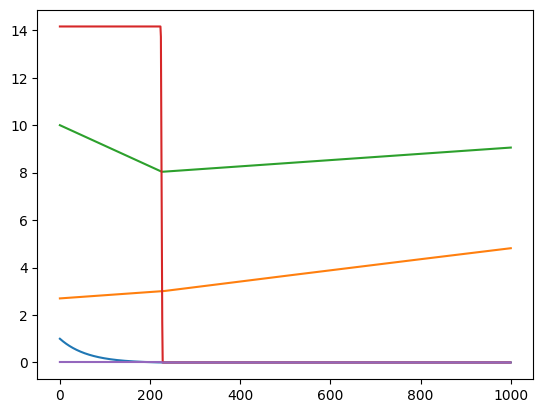

In [9]:
plt.plot(ll.value(mpc_obj.C).T)
plt.plot(ll.value(mpc_obj.Q).T)
plt.plot(ll.value(mpc_obj.lambda_).T)
print(max(ll.value(mpc_obj.lambda_)))

In [45]:
sol1 = mpc_obj.solve()


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1803
Number of nonzeros in inequality constraint Jacobian.:     1203
Number of nonzeros in Lagrangian Hessian.............:      800

Total number of variables............................:      803
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:     1203
        inequality constraints with only lower bounds:     1003
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+01 5.37e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [47]:
print(sol1.stats()["iter_count"])
print(sol1.value(mpc_obj.C))
print(sol1.value(mpc_obj.Q))

26
[[ 1.00000000e+01  9.89830000e+00  9.79761700e+00  9.69794083e+00
   9.59926142e+00  9.50156880e+00  9.40485311e+00  9.30910458e+00
   9.21431354e+00  9.12047040e+00  9.02756569e+00  8.93559004e+00
   8.84453414e+00  8.75438879e+00  8.66514490e+00  8.57679345e+00
   8.48932552e+00  8.40273226e+00  8.31700494e+00  8.23213489e+00
   8.14811354e+00  8.06493240e+00  7.98258308e+00  7.90105725e+00
   7.82034667e+00  7.74044321e+00  7.66133877e+00  7.58302538e+00
   7.50549513e+00  7.42874018e+00  7.35275277e+00  7.27752525e+00
   7.20304999e+00  7.12931949e+00  7.05632630e+00  6.98406303e+00
   6.91252240e+00  6.84169718e+00  6.77158020e+00  6.70216440e+00
   6.63344275e+00  6.56540833e+00  6.49805424e+00  6.43137370e+00
   6.36535996e+00  6.30000636e+00  6.23530630e+00  6.17125323e+00
   6.10784070e+00  6.04506229e+00  5.98291167e+00  5.92138255e+00
   5.86046872e+00  5.80016404e+00  5.74046239e+00  5.68135777e+00
   5.62284419e+00  5.56491575e+00  5.50756659e+00  5.45079092e+00
   5.39